# PT-BR Financial News Classification
- This approach applied a labelling method that involved observing whether the USD/BRL exchange rate increased, decreased, or experienced low volatility (neutral)
- A threshold of 0.2% was applied to determine neutral days

Checking Dates in articles

In [ ]:
# Just checking what dates are in our file filled with articles

import re
import pandas as pd

def extract_dates_from_file(file_path):
    date_pattern = r'\d{2}/\d{2}/\d{2}'
    dates = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        matches = re.findall(date_pattern, content)
        dates.extend(matches)
    
    dates_df = pd.DataFrame(dates, columns=['Date'])
    return dates_df

file_path = 'data/news_corpus_cleaned.txt'
dates_df = extract_dates_from_file(file_path)
display(dates_df)

,Date
0,09/01/24
1,10/01/24
2,11/01/24
3,12/01/24
4,15/01/24
5,16/01/24
6,19/01/24
7,22/01/24
8,23/01/24
9,24/01/24


Organizing article file data into a DataFrame for readability and easier to convert to CSV

In [ ]:
import pandas as pd
import re
from datetime import datetime

# this is where we look at the file and make it into a list
def parse_articles_to_df(file_path):
    dates = []  # this is where we keep the dates
    articles = []  # this is where we keep the articles
    
    with open(file_path, "r", encoding="utf-8") as file:
        current_date = None  # this is where we keep the date we are looking at right now
        current_articles = []  # this is where we keep the article for the current date
        
        for line in file:
            line = line.strip()  # take away spaces from the start and end
            if line:  # if the line is not empty
                if line[2] == "/":  # if the line looks like a date (dd/mm/yy)
                    # we had a date before, so let's save it with its articles
                    if current_date:
                        for article in current_articles:
                            dates.append(current_date)  # add the current date
                            articles.append(article)  # add the article for that date
                    # just use the date as is, don't change it
                    current_date = line  # keep the new date
                    current_articles = []  # start fresh for the new date
                else:
                    # this is the article, we keep adding it to the list
                    current_articles.append(line) 
        
        if current_date:  # when we are done looking at the file
            for article in current_articles:  # for all the articles we saved
                dates.append(current_date)  # add the date again
                articles.append(article)  # add the article again
    
    df = pd.DataFrame({'date': dates, 'article': articles})  # make a table with the dates and articles
    return df  # give back the table

file_path = "data/news_corpus_cleaned.txt"  # where the file is
df_articles = parse_articles_to_df(file_path)  # call the function to make the table

# show the table to see it
display(df_articles)

,date,article
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no..."
1,09/01/24,Circularam comentários de que a reunião de Pac...
2,09/01/24,"De qualquer modo, seis senadores estão com a p..."
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (..."
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro..."
...,...,...
1096,31/01/24,Emissão é de apenas uma série e já tem valor d...
1097,31/01/24,"ROMI teve lucro líquido de R$ 51,340 milhões n..."
1098,31/01/24,ENEVA. Citi manteve recomendação de compra par...
1099,31/01/24,OI. Nova versão do plano de recuperação judici...


Preproccesing & cleaning

In [3]:
import spacy

# spacy PT model
nlp = spacy.load('pt_core_news_sm')

#preprocessing
def preprocess_text_spacy(text):
    doc = nlp(text)
    
    # lemmatization and stopwords removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    #tokens back to 1 string
    return ' '.join(tokens)

# preprocess ALL articles in df (the file)
df_articles['processed_article'] = df_articles['article'].apply(preprocess_text_spacy)

# Display the processed articles
display(df_articles[['date', 'processed_article']])

,date,processed_article
0,09/01/24,petróleo testar reação moderar pregão asiático...
1,09/01/24,circularam comentário reunião Pacheco líder se...
2,09/01/24,modo senador presença confirmar Único indicado...
3,09/01/24,EUA sair balança comercial novembro Fed boy Mi...
4,09/01/24,investidor cumprir espera prometer emoção CPI ...
...,...,...
1096,31/01/24,Emissão série definir revelar executivo
1097,31/01/24,ROMI lucro líquido milhão queda
1098,31/01/24,ENEVA Citi manter recomendação compra ação ban...
1099,31/01/24,OI versão plano recuperação judicial concluir ...


Applying the Word2Vec approach

In [4]:
from gensim.models import Word2Vec

tokenized_articles = df_articles['processed_article'].apply(lambda x: x.split()).tolist()

model = Word2Vec(sentences=tokenized_articles, 
                 vector_size=100,   # dimensionality of the word embeddings
                 window=5,          # context window size
                 min_count=5,       # minimum frequency of words to consider
                 workers=4,         # CPUs for training
                 sg=0)              # Use CBOW (0) or Skip-Gram (1)

model.save("word2vec_brl_model.model")

Counting the number of each label in our data (3 classes)
- helps us to realize a class imbalance
- good to keep track of

In [ ]:
import pandas as pd

file_path = 'labeled_articles.csv'
df = pd.read_csv(file_path)

column_name = 'label'
column_data = df[column_name]

df_articles['label'] = column_data

counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]

print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")

Count of 1: 182
Count of -1: 363
Count of 0: 556


Labelling of all articles on trading day "d" based on whether the USD/BRL exchange rate increased/decreased or hovered around a .5% increase/decrease on trading day "d"
- Increase: +1
- Decrease: -1
- Neutral: 0

fail

In [6]:
'''
# Word2Vec approach by applying +1, -1, 0 labels to ALL articles per trading day whether the BRL went up down or stayed around the same based on a .2% threshold.
# 0 for neutral
# +1 for up
# -1 for down

labels = {
    '09/01/24': 1,
    '10/01/24': 0,
    '11/01/24': -1,
    '12/01/24': -1, 
    '15/01/24': 1,
    '16/01/24': 1,
    '19/01/24': 0,
    '22/01/24': 1,
    '23/01/24': -1,
    '24/01/24': -1,
    '25/01/24': -1,
    '26/01/24': -1,
    '29/01/24': 1,
    '30/01/24': 1,
    '31/01/24': 1
}

# add lablels to df
df_articles['label'] = df_articles['date'].map(labels)
'''


"\n# Word2Vec approach by applying +1, -1, 0 labels to ALL articles per trading day whether the BRL went up down or stayed around the same based on a .2% threshold.\n# 0 for neutral\n# +1 for up\n# -1 for down\n\nlabels = {\n    '09/01/24': 1,\n    '10/01/24': 0,\n    '11/01/24': -1,\n    '12/01/24': -1, \n    '15/01/24': 1,\n    '16/01/24': 1,\n    '19/01/24': 0,\n    '22/01/24': 1,\n    '23/01/24': -1,\n    '24/01/24': -1,\n    '25/01/24': -1,\n    '26/01/24': -1,\n    '29/01/24': 1,\n    '30/01/24': 1,\n    '31/01/24': 1\n}\n\n# add lablels to df\ndf_articles['label'] = df_articles['date'].map(labels)\n"

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
import itertools  # needed this for combinations

# function to get the article vector by averaging word vectors
def get_article_vector(article, model):
    tokens = article.split()  # split the article into words
    # get the word vectors for each word that exists in the model's vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:  # if there are any word vectors
        return np.mean(vectors, axis=0)  # average them to get a single vector
    else:
        return np.zeros(model.vector_size)  # if no word vectors, return a zero vector

# convert all articles into vectors
df_articles['article_vector'] = df_articles['processed_article'].apply(lambda x: get_article_vector(x, model))

# assuming 'labels' is a column with +1, 0, -1 labels
labels = df_articles['label'].values  # get the labels

In [9]:
# Checking the data we're working with before feeding it into the model

df_articles.to_csv('input_log_reg.csv')

Multinomial Logistic Regression Model with Custom Word2Vec Model

Next steps:
- Apply softmax to improve accuracy
- Train on January, test on first 2 weeks of February
    - Or grab equal amounts of each label and make sure to test on NEW articles since the training data may come from spread out dates

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Step 1: Prepare the data (X = article vectors, y = labels)
X = np.vstack(df_articles['article_vector'].values)
y = df_articles['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    C=1.0,
    penalty='l2'
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

X_all = np.vstack(df_articles['article_vector'].values)
predicted_labels = clf.predict(X_all)
df_articles['predicted_label'] = predicted_labels

# Save the updated DataFrame to a file
df_articles.to_csv("classified_articles.csv", index=False, encoding="utf-8")

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)  # Get classification report as dictionary

# Convert evaluation results into DataFrames for better display
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Step 6: Display the results
print("Accuracy:", accuracy)
display("Classification Report:")
display(classification_rep_df)

display(df_articles)

Accuracy: 0.5203619909502263


'Classification Report:'

,precision,recall,f1-score,support
-1,0.487179,0.670588,0.564356,85.000000
0,0.559140,0.530612,0.544503,98.000000
1,0.545455,0.157895,0.244898,38.000000
accuracy,0.520362,0.520362,0.520362,0.520362
macro avg,0.530591,0.453032,0.451252,221.000000
weighted avg,0.529110,0.520362,0.500623,221.000000


,date,article,processed_article,label,article_vector,predicted_label
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no...",petróleo testar reação moderar pregão asiático...,0,"[-0.008307134, 0.027291108, 0.0009818356, 0.00...",0
1,09/01/24,Circularam comentários de que a reunião de Pac...,circularam comentário reunião Pacheco líder se...,0,"[-0.010316576, 0.03773768, -0.001305207, 0.003...",0
2,09/01/24,"De qualquer modo, seis senadores estão com a p...",modo senador presença confirmar Único indicado...,0,"[-0.0060591586, 0.04269991, 0.0027297675, -0.0...",0
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (...",EUA sair balança comercial novembro Fed boy Mi...,-1,"[-0.012737384, 0.052136607, -0.0012424898, 0.0...",-1
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro...",investidor cumprir espera prometer emoção CPI ...,-1,"[-0.01746947, 0.065396346, 0.0012987641, 0.007...",-1
...,...,...,...,...,...,...
1096,31/01/24,Emissão é de apenas uma série e já tem valor d...,Emissão série definir revelar executivo,0,"[-0.0005740447, 0.031521242, -0.0071695806, -8...",0
1097,31/01/24,"ROMI teve lucro líquido de R$ 51,340 milhões n...",ROMI lucro líquido milhão queda,0,"[-0.014905481, 0.043765545, -0.0010301427, 0.0...",0
1098,31/01/24,ENEVA. Citi manteve recomendação de compra par...,ENEVA Citi manter recomendação compra ação ban...,0,"[-0.008786327, 0.041730143, -0.0018656082, 0.0...",0
1099,31/01/24,OI. Nova versão do plano de recuperação judici...,OI versão plano recuperação judicial concluir ...,0,"[-0.017070906, 0.049991395, -0.004382461, 0.00...",-1


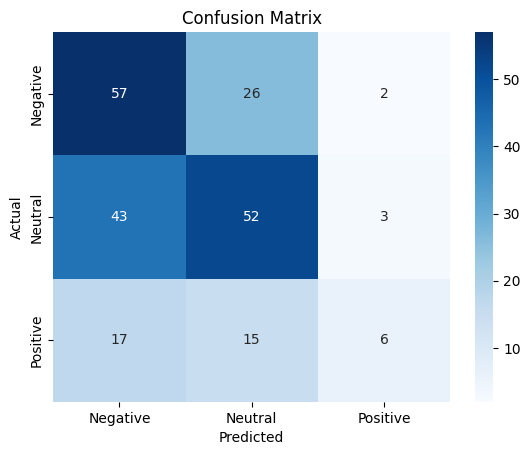

In [11]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is actual labels and y_pred is predicted labels
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# display plot
plt.show()

In [12]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import adjusted_rand_score, confusion_matrix
# import numpy as np

# kmeans = KMeans(n_clusters=3, random_state=42)
# df_articles['kmeans_labels'] = kmeans.fit_predict(np.array(df_articles['article_vector'].tolist()))
# y_true = df_articles['label'].values
# y_pred = df_articles['kmeans_labels'].values

# def purity_score(y_true, y_pred):
#     contingency_matrix = confusion_matrix(y_true, y_pred)
#     return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# purity = purity_score(y_true, y_pred)
# print(f'Purity Score: {purity}')

In [13]:
# import fasttext
# import fasttext.util
# ft = fasttext.load_model('cc.pt.300.bin')

# def get_article_embedding(article, model):
#     # Tokenize the article (assuming it's already preprocessed)
#     tokens = article.split()
    
#     # Get the embedding for each word in the article and average them
#     word_embeddings = [model.get_word_vector(word) for word in tokens]
    
#     # Compute the average of the word embeddings
#     article_embedding = np.mean(word_embeddings, axis=0)
    
#     return article_embedding

# # Example: Get the embedding for the first article in your dataframe
# article = df_articles['processed_article'].iloc[0]
# article_embedding = get_article_embedding(article, ft)
# print(article_embedding)

# # RETURNED .45 accuracy (sucks) so lets try labelling different
